# Tutorial 2: Regressors from  pulse oximeter data

This example shows how to use *niphlem* for one subject from one of our particular projects. These data consist of one acquisition of resting-state that has been previously preprocesses using *fMRIPrep* and physiological acquired through a Siemens multiband protocol. Here we concentrate on pulse oximeter data, which contains both breathing (lower frequencies) and cardiac signal (higher frequencies). Look at Verstynen, 2011 for more details on this.

In addition, we are going to show the maps generated by the *niphlem* generated regressors using the library *nilearn* (https://nilearn.github.io/)

In [1]:
# IMPORTS
import numpy as np
import pandas as pd

from nilearn import image, plotting
from nilearn.glm.first_level import FirstLevelModel

from niphlem.input_data import (load_cmrr_info, load_cmrr_data)

/home/javi/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


Let's start definining our data

In [2]:
# Our preprocessed BOLD image
run_img = image.load_img("data/demo/sub-06_ses-04_task-resting_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
# The repetition time of the scanner
t_r = 1.5
# The frame times, used to define the regressors at the precise times
n_vols = run_img.shape[-1]
frame_times = np.arange(n_vols)*t_r
# Our file with the confounder regressors as a Dataframe. It will be used later to extract the motion parameters
conf_df = pd.read_csv("data/demo/sub-06_ses-04_task-resting_run-01_desc-confounds_regressors.tsv", sep="\t")

# Our physiological data, the info log file and the Pulse-ox log file
info_log = "./data/demo/physio/Physio_20210322_140315_89a222d1-4c24-4caf-a898-f06c6bfd2342_Info.log"
pulse_log = "./data/demo/physio/Physio_20210322_140315_89a222d1-4c24-4caf-a898-f06c6bfd2342_PULS.log"

### Load data

The first thing that we need is to load the info file, which will give us the times of the scanner. We can load this kind of the data using the function `niphlem.input_data.load_cmrr_info`. The only thing that we have to do is to pass the info log file to this function, and it will return the time traces and a dictionary with some meta information which is at the beginning of the file.

In [3]:
time_traces, meta_info = load_cmrr_info(info_log)

In [4]:
meta_info

{'uuid': '89a222d1-4c24-4caf-a898-f06c6bfd2342',
 'scan_date': '20210322_140315',
 'log_version': 'EJA_1',
 'n_slices': 68,
 'n_vols': 353,
 'n_echoes': 1,
 'init_physio': 20241969,
 'end_physio': 20457989,
 'init_scan': 20246200,
 'end_scan': 20457978,
 'repetition_time': 600.0}

Now that we have the time traces, we are going to load our pulse-ox data by passing to the function `niphlem.input_data.load_cmrr_data` its log file and the meta information dictionary that we've just generated. This dictionary is required to be able to synchronize the physiological signal with the scanner times. We also specify the type of signal, as a new entry to an updated dictionary will be added, containing meta information of this  pulse-ox signal.

In [5]:
pulse_signal, meta_info = load_cmrr_data(pulse_log, info_dict=meta_info, sig_type="pulse")

Let's have a look at the updated information dictionary.

In [6]:
meta_info

{'uuid': '89a222d1-4c24-4caf-a898-f06c6bfd2342',
 'scan_date': '20210322_140315',
 'log_version': 'EJA_1',
 'n_slices': 68,
 'n_vols': 353,
 'n_echoes': 1,
 'init_physio': 20241969,
 'end_physio': 20457989,
 'init_scan': 20246200,
 'end_scan': 20457978,
 'repetition_time': 600.0,
 'pulse': {'n_channels': 1, 'sample_rate': 2}}

Let's have a look into a portion of this signal, corresponding to 4 s

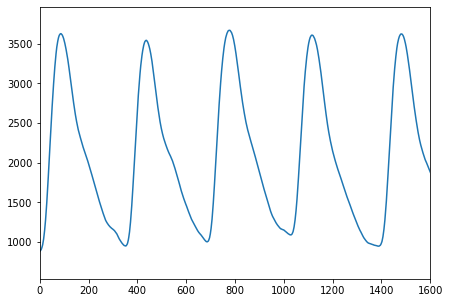

In [7]:
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(pulse_signal[:,0])
plt.xlim([0,1600])
pass

If we inspect the the power spectrum, we could see that there are roughly two peaks, one between [0.1-0.5], corresponding to breathing effects, and another one between [0.5-2], corresponding to cardiac effects (Verstynen, 2011)

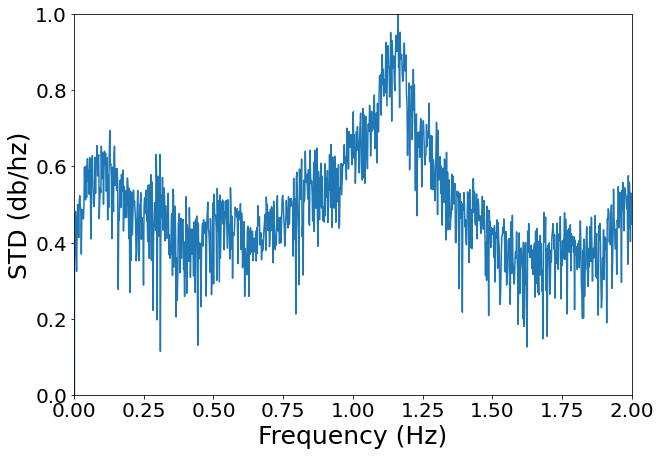

In [8]:
from scipy.signal import periodogram

f, Pxx = periodogram(pulse_signal.flatten(), fs=400)
max_pxx = max(10*np.log10(Pxx))

fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(f, 10*np.log10(Pxx)/max_pxx)
plt.xlim([0, 2])
plt.ylim([0, 1])
plt.tick_params(labelsize=20)
plt.xlabel("Frequency (Hz)", size=25)
plt.ylabel("STD (db/hz)", size=25)
pass

Thus, in the following we are going to consider two signal, a lowpassed filtered signal accounting for breathing effects, and a highpassed filtered signal for cardiac effects. Let's have a look at how these look like, for which we are going to get help of the function *_transform_filter* in the **clean** module  We are also going to show the peaks detected, for which we will employ the function *compute_max_events* from  **events** module.

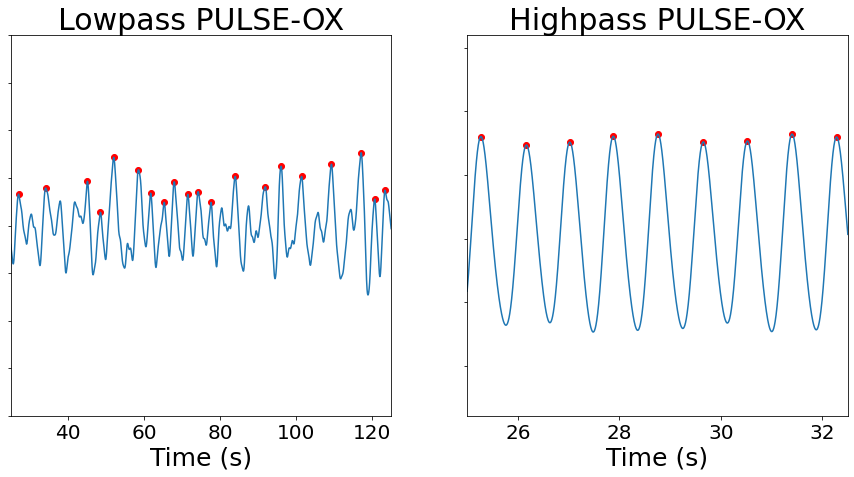

In [9]:
from niphlem.clean import _transform_filter
from niphlem.events import compute_max_events

puls_filt_low = _transform_filter(pulse_signal[:,0],
                                  high_pass=0.1,
                                  low_pass=0.5,
                                  sampling_rate=400)

puls_filt_high = _transform_filter(pulse_signal[:,0],
                                   low_pass=2,
                                   high_pass=0.5,
                                   sampling_rate=400)

times = np.arange(pulse_signal.shape[0])*1/400

fig, axs = plt.subplots(ncols=2, figsize=(15, 7))

axs[0].plot(times, puls_filt_low)

# delta 800 corresponds to 0.5 Hz as the fastest frequency, i.e. 60 breats per minute 
pks = compute_max_events(puls_filt_low, delta=800, peak_rise=0.5)
axs[0].scatter(times[pks], puls_filt_low[pks], c="r")
axs[0].set_xlim([10000/400, 50000/400])
axs[0].set_ylim([-200, 200])
axs[0].set_xlabel("Time (s)", size=25)
axs[0].set_yticklabels("")
axs[0].tick_params(labelsize=20)
axs[0].set_title("Lowpass PULSE-OX", size=30)

axs[1].plot(times, puls_filt_high)
# delta 200 corresponds to 2 Hz as the fastest frequency
pks = compute_max_events(puls_filt_high, delta=200, peak_rise=0.5)
axs[1].scatter(times[pks], puls_filt_high[pks], c="r")
axs[1].set_xlim([10000/400, 13000/400])
axs[1].set_xlabel("Time (s)", size=25)
axs[1].set_yticklabels("")
axs[1].tick_params(labelsize=20)
axs[1].set_title("Highpass PULSE-OX", size=30)
pass

### Retroicor regressors

Let's start the generation of regressors for the Retroicor Model. The class for generating these regressors is found as `niphlem.models.RetroicorPhysio`.

In [10]:
from niphlem.models import RetroicorPhysio

In [11]:
print(RetroicorPhysio.__doc__)


     Physiological regressors using Retroicor.

    Parameters
    ----------
    physio_rate : float
        Sampling rate for the recording in Hz.
        This is needed for filtering to define the nyquist frequency.
    t_r : float
        Repetition time for the scanner (the usual T_R) in secs.
    delta: float
        minimum separation (in physio recording units) between
        events in signal to be considered peaks
    peak_rise: float
        relative height with respect to the 20th tallest events in signal
        to consider events as peak.
    order: int or array-like of shape (n_orders,)
        Fourier expansion for phases. If int, the fourier expansion is
        performed to that order, starting from 1. If an array is provided,
        each element will multiply the phases.
    transform : {"demean", "zscore", "abs"}, optional
        Transform data before filtering. The default is "demean".
    high_pass : float, optional
        High-pass filtering frequency (in Hz)

Let's define the objects for both kinds of data. They will be differenciated mainly in the frequency ranges to be passed

In [12]:
retro_breath = RetroicorPhysio(physio_rate=400, # Physiological rate (400 Hz)
                               t_r=1.5, # Scan rate (1.5 s)
                               delta=800,
                               peak_rise=0.5,
                               high_pass=0.1,
                               low_pass=0.5, # keep frequencies below this
                               order=2 # order 2 of the retroicor expansion
                              )

retro_cardiac = RetroicorPhysio(physio_rate=400, # Physiological rate (400 Hz)
                                t_r=1.5, # Scan rate (1.5 s)
                                delta=200,
                                peak_rise=0.5,
                                low_pass=2.0, # keep frequencies below this
                                high_pass=0.5, # keep frequencies above this
                                order=2 # order 2 of the retroicor expansion
                           )

Once we have defined this object, we generate the regressors using the method `compute_regressors`, which is comon to all the models

In [13]:
breath_regressors = retro_breath.compute_regressors(signal=pulse_signal, time_scan=frame_times)
cardiac_regressors = retro_cardiac.compute_regressors(signal=pulse_signal, time_scan=frame_times)

Let's see the a part of these regressors

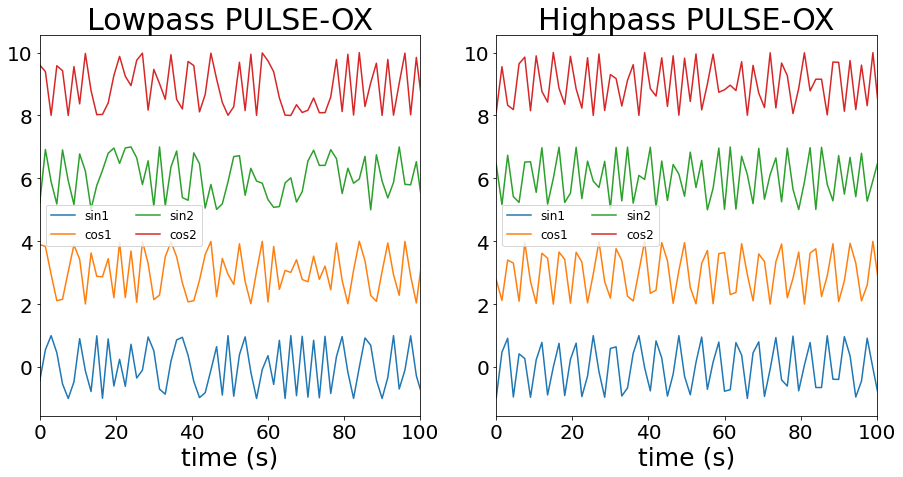

In [14]:
fig, axs = plt.subplots(figsize=(15,7), ncols=2, sharex=True)
axs[0].plot(frame_times, breath_regressors[:,0], label="sin1")
axs[0].plot(frame_times, 3 + breath_regressors[:,1], label="cos1")
axs[0].plot(frame_times, 6 + breath_regressors[:,2], label="sin2")
axs[0].plot(frame_times, 9 + breath_regressors[:,3], label="cos2")
axs[0].legend(ncol=2, prop={'size':12})
axs[0].set_xlabel("time (s)", size=25)
axs[0].set_xlim([0,100])
axs[0].tick_params(labelsize=20)
axs[0].set_title("Lowpass PULSE-OX", size=30)

axs[1].plot(frame_times, cardiac_regressors[:,0], label="sin1")
axs[1].plot(frame_times, 3 + cardiac_regressors[:,1], label="cos1")
axs[1].plot(frame_times, 6 + cardiac_regressors[:,2], label="sin2")
axs[1].plot(frame_times, 9 + cardiac_regressors[:,3], label="cos2")
axs[1].legend(ncol=2, prop={'size':12})
axs[1].set_xlabel("time (s)", size=25)
axs[1].set_xlim([0,100])
axs[1].tick_params(labelsize=20)
axs[1].set_title("Highpass PULSE-OX", size=30)
pass

Let's build now a design matrix that contains these regressors in addition to the motion parameters and an intercept.

In [15]:
dm_retroicor = np.column_stack((np.ones(len(frame_times)), # Intercept
                                conf_df.filter(regex="rot|trans").to_numpy(), # Motion parameters
                                breath_regressors, # breath retro regressors
                                cardiac_regressors, # cardiac retro regressors
                               ))
dm_retroicor = pd.DataFrame(dm_retroicor, 
                            columns=["intercept", 
                                     "trans_x","trans_y","trans_z","rot_x","rot_y","rot_z",
                                     "breath_sin1", "breath_cos1", "breath_sin2", "breath_cos2",
                                     "cardiac_sin1", "cardiac_cos1", "cardiac_sin2", "cardiac_cos2",
                                      ]
                     )
dm_retroicor.index=frame_times
dm_retroicor.head()

,intercept,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,breath_sin1,breath_cos1,breath_sin2,breath_cos2,cardiac_sin1,cardiac_cos1,cardiac_sin2,cardiac_cos2
0.0,1.0,0.031165,-0.003878,-0.027213,-0.001164,0.000187,0.000000,-0.444137,0.895959,-0.795857,0.605484,-0.973793,-0.227434,0.442948,-0.896547
1.5,1.0,0.021195,-0.071983,-0.047930,0.000039,0.000260,0.000000,0.549509,0.835488,0.918216,0.396080,0.474220,-0.880406,-0.835013,0.550230
3.0,1.0,0.017855,-0.041552,-0.036992,0.000027,0.000076,-0.000260,0.998598,-0.052943,-0.105737,-0.994394,0.915408,0.402527,0.736953,-0.675944
4.5,1.0,0.013670,0.072409,-0.036982,-0.000340,0.000188,-0.000202,0.458086,-0.888908,-0.814393,0.580314,-0.952076,0.305862,-0.582408,-0.812897
6.0,1.0,0.009882,-0.046013,-0.040077,0.000352,0.000367,-0.000228,-0.536384,-0.843974,0.905388,0.424585,0.420688,-0.907205,-0.763301,0.646043


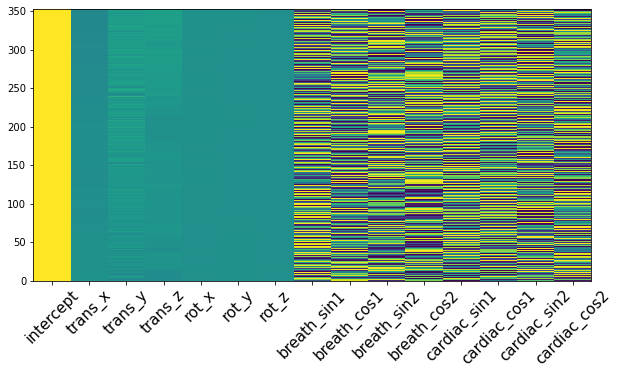

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.pcolormesh(dm_retroicor)
ax.set_xticks(0.5 + np.arange(dm_retroicor.shape[1]))
ax.set_xticklabels(dm_retroicor.columns, rotation=45, size=15)
pass

Now fit this design matrix to our BOLD image

In [17]:
first_level = FirstLevelModel(t_r=t_r, drift_model=None, signal_scaling=False, smoothing_fwhm=6)
first_level.fit(run_imgs=run_img, design_matrices=dm_retroicor)

breath_retro_map = first_level.compute_contrast("breath_sin1+breath_cos1+breath_sin2+breath_cos2", 
                                                stat_type="F", output_type="z_score")

cardiac_retro_map = first_level.compute_contrast("cardiac_sin1+cardiac_cos1+cardiac_sin2+cardiac_cos2", 
                                                 stat_type="F", output_type="z_score")

And show the z-stat maps for both

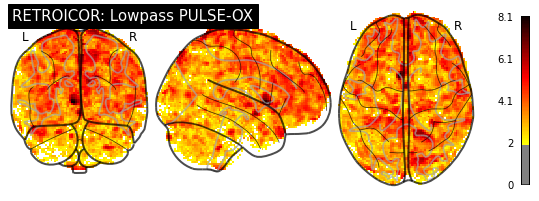

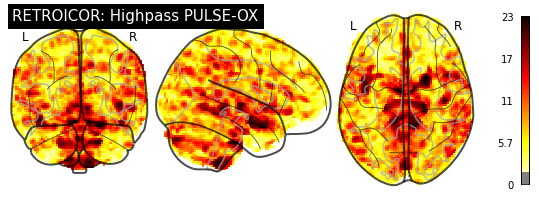

In [18]:
plotting.plot_glass_brain(breath_retro_map,  threshold=1.96, colorbar=True, 
                          title="RETROICOR: Lowpass PULSE-OX")
plotting.plot_glass_brain(cardiac_retro_map, threshold=1.96, colorbar=True, 
                          title="RETROICOR: Highpass PULSE-OX")

### Variation model's regressors

Let's continue now with the generation of regressors using the Variation Model. The classes for generating these regressors are found as `niphlem.models.HVPhysio` for cardiac effects, and `niphlem.models.RVPhysio` for breathing effects.

In [19]:
from niphlem.models import HVPhysio, RVPhysio

Let's look at the documentation of both

In [20]:
print(RVPhysio.__doc__)


     Physiological regressors for variations in breathing rate/volume.

    Parameters
    ----------
    physio_rate : float
        Sampling rate for the recording in Hz.
        This is needed for filtering to define the nyquist frequency.
    t_r : float
        Repetition time for the scanner (the usual T_R) in secs.
    time_window : float
        Time window (in secs) around the T_R from which computing variations
        (standard deviation of signal). The default is 6 secs.
    transform : {"demean", "zscore", "abs"}, optional
        Transform data before filtering. The default is "demean".
    high_pass : float, optional
        High-pass filtering frequency (in Hz). The default is None.
    low_pass : float, optional
        Low-pass filtering frequency (in Hz). The default is None.
    columns : List or array of n_channels elements, "mean" or None, optional
        It describes how to handle input signal channels. If a list, it will
        weight each channel and take th

In [21]:
print(HVPhysio.__doc__)


     Physiological regressors for variations in heart rate.

    Parameters
    ----------
    physio_rate : float
        Sampling rate for the recording in Hz.
        This is needed for filtering to define the nyquist frequency.
    t_r : float
        Repetition time for the scanner (the usual T_R) in secs.
    delta: float
        minimum separation (in physio recording units) between
        events in signal to be considered peaks
    peak_rise: float
        relative height with respect to the 20th tallest events in signal
        to consider events as peak.
    time_window : float
        Time window (in secs) around the T_R from which computing variations
        (time differences between signal events ). The default is 6 secs.
    transform : {"demean", "zscore", "abs"}, optional
        Transform data before filtering. The default is "demean".
    high_pass : float, optional
        High-pass filtering frequency (in Hz). The default is None.
    low_pass : float, optional
 

In [22]:
variaton_breath = RVPhysio(physio_rate=400, 
                           t_r=t_r, 
                           time_window=4.5, # 3 T_R
                           low_pass=0.5, 
                           high_pass=0.1)

variaton_cardiac = HVPhysio(physio_rate=400, 
                            t_r=t_r, 
                            delta=200, 
                            peak_rise=0.5, 
                            time_window=4.5, # 3 T_R
                            low_pass=2.0, 
                            high_pass=0.5)

As before, we can generate the regressors using the method `compute_regressors`.

In [23]:
breath_regressors = variaton_breath.compute_regressors(signal=pulse_signal, time_scan=frame_times)
cardiac_regressors = variaton_cardiac.compute_regressors(signal=pulse_signal, time_scan=frame_times)

Let's plot a snapshot of both

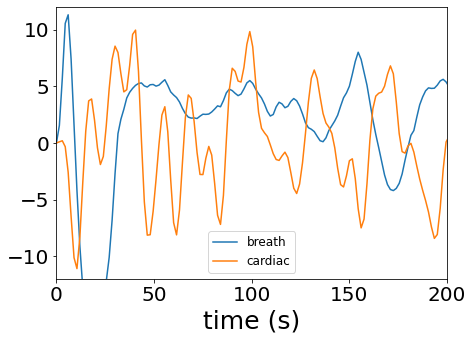

In [24]:
fig, axs = plt.subplots(figsize=(7,5))
axs.plot(frame_times, breath_regressors[:,0], label="breath")
axs.plot(frame_times, cardiac_regressors[:,0], label="cardiac")
plt.xlim([0, 200])
plt.ylim([-12,12])
plt.xlabel("time (s)", size=25)
plt.legend(prop={'size':12})
plt.tick_params(labelsize=20)
pass

In [25]:
dm_variation = np.column_stack((np.ones(len(frame_times)), # Intercept
                                conf_df.filter(regex="rot|trans").to_numpy(), # Motion parameters
                                breath_regressors, # breath variation regressors
                                cardiac_regressors, # cardiac variation regressors
                         ))

dm_variation = pd.DataFrame(dm_variation, 
                            columns=["intercept", 
                                     "trans_x","trans_y","trans_z","rot_x","rot_y","rot_z",
                                     "breath_var", 
                                     "cardiac_var"
                                    ]
                     )
dm_variation.index=frame_times
dm_variation.head()

,intercept,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,breath_var,cardiac_var
0.0,1.0,0.031165,-0.003878,-0.027213,-0.001164,0.000187,0.000000,0.000000,-0.000102
1.5,1.0,0.021195,-0.071983,-0.047930,0.000039,0.000260,0.000000,1.550640,0.099650
3.0,1.0,0.017855,-0.041552,-0.036992,0.000027,0.000076,-0.000260,5.713570,0.189940
4.5,1.0,0.013670,0.072409,-0.036982,-0.000340,0.000188,-0.000202,10.554199,-0.337274
6.0,1.0,0.009882,-0.046013,-0.040077,0.000352,0.000367,-0.000228,11.312013,-2.589158


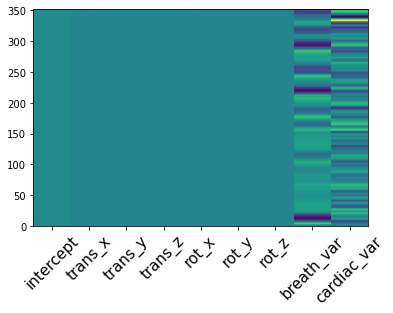

In [26]:
fig, ax = plt.subplots()
ax.pcolormesh(dm_variation)
ax.set_xticks(0.5 + np.arange(dm_variation.shape[1]))
ax.set_xticklabels(dm_variation.columns, rotation=45, size=15)
pass

As before, let's fit this design matrix to our BOLD data

In [27]:
first_level = FirstLevelModel(t_r=t_r, drift_model=None, signal_scaling=False, smoothing_fwhm=6)
first_level.fit(run_imgs=run_img, design_matrices=dm_variation)

breath_variation_map = first_level.compute_contrast("breath_var", 
                                                stat_type="F", output_type="z_score")

cardiac_variation_map = first_level.compute_contrast("cardiac_var", 
                                                 stat_type="F", output_type="z_score")

And plot these maps

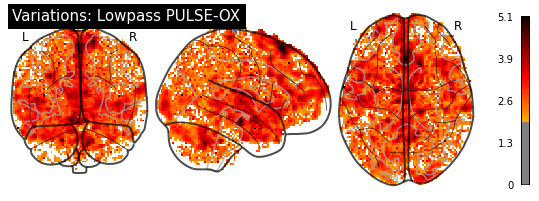

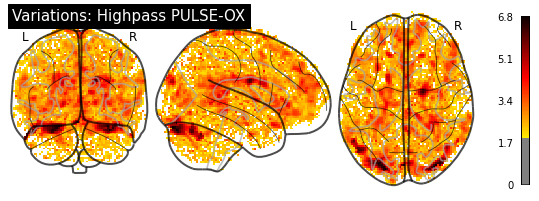

In [28]:
plotting.plot_glass_brain(breath_variation_map,  threshold=1.96, colorbar=True, 
                          title="Variations: Lowpass PULSE-OX")
plotting.plot_glass_brain(cardiac_variation_map, threshold=1.96, colorbar=True, 
                          title="Variations: Highpass PULSE-OX")